KeyboardInterrupt: 

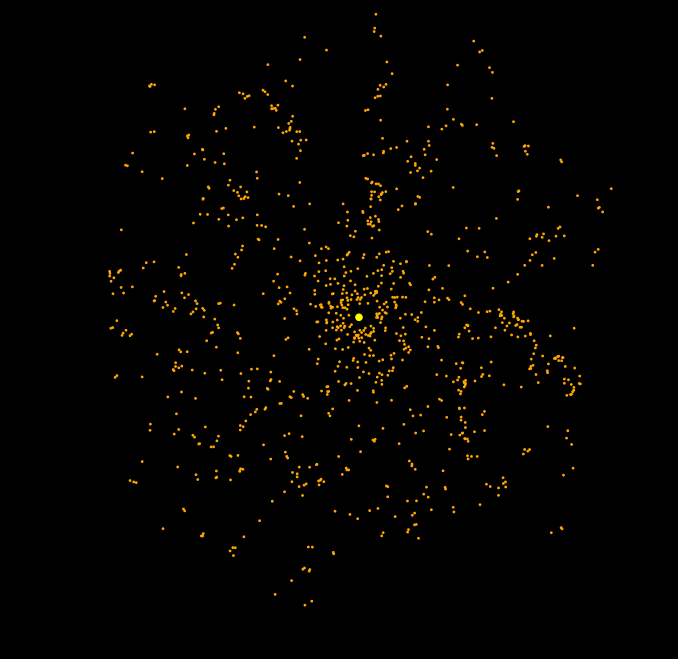

In [21]:
import numpy as np
import random
import numba as nb
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Gravitational constant (arbitrary units, we can set G = 1 for simplicity)
G = 1

# Define the structured array (dtype) for the Body object
body_dtype = np.dtype([
    ('position', np.float64, (2,)),  # 2D position (x, y)
    ('velocity', np.float64, (2,)),  # 2D velocity (vx, vy)
    ('mass', np.float64),            # Mass
    ('size', np.float64),            # Size
    ('color', 'U10')                 # Color (as string)
])

# Initialize an array of bodies
def initialize_bodies(num_bodies, max_radius, mass_central, particle_mass, particle_size, particle_color, central_body_size, central_body_color):
    bodies = np.zeros(num_bodies, dtype=body_dtype)
    
    for i in range(num_bodies):
        r = random.uniform(max_radius * 0.05, max_radius * 0.9)
        theta = random.uniform(0, 2 * np.pi)
        x, y = r * np.cos(theta), r * np.sin(theta)  # Polar to Cartesian
        
        # Calculate velocity for stable circular orbit
        v = np.sqrt(G * mass_central / r)
        vx, vy = -v * np.sin(theta), v * np.cos(theta)  # Tangential velocity

        bodies[i]['position'] = [x, y]
        bodies[i]['velocity'] = [vx, vy]
        bodies[i]['mass'] = particle_mass
        bodies[i]['size'] = particle_size
        bodies[i]['color'] = particle_color

    # Add the central massive body
    central_body = np.zeros(1, dtype=body_dtype)
    central_body['position'] = [0, 0]
    central_body['velocity'] = [0, 0]
    central_body['mass'] = mass_central
    central_body['size'] = central_body_size
    central_body['color'] = central_body_color

    return np.concatenate([bodies, central_body])

# Define the insert_body function compatible with Numba
@nb.njit
def insert_body(quad_tree, bodies, body_idx, nw, se, max_depth=10):
    if max_depth == 0:
        return

    midX = (nw[0] + se[0]) / 2
    midY = (nw[1] + se[1]) / 2

    # Determine the quadrant to insert the body
    if bodies[body_idx]['position'][0] <= midX:
        if bodies[body_idx]['position'][1] <= midY:
            # NW quadrant
            if quad_tree[0] == -1:
                quad_tree[0] = body_idx
            else:
                insert_body(quad_tree, bodies, body_idx, nw, (midX, midY), max_depth - 1)
        else:
            # SW quadrant
            if quad_tree[1] == -1:
                quad_tree[1] = body_idx
            else:
                insert_body(quad_tree, bodies, body_idx, (nw[0], midY), (midX, se[1]), max_depth - 1)
    else:
        if bodies[body_idx]['position'][1] <= midY:
            # NE quadrant
            if quad_tree[2] == -1:
                quad_tree[2] = body_idx
            else:
                insert_body(quad_tree, bodies, body_idx, (midX, nw[1]), se, max_depth - 1)
        else:
            # SE quadrant
            if quad_tree[3] == -1:
                quad_tree[3] = body_idx
            else:
                insert_body(quad_tree, bodies, body_idx, (midX, midY), se, max_depth - 1)

# Define a Numba-compatible quadtree builder
@nb.njit
def build_quad_tree(bodies, nw, se, max_depth=10):
    """ Build the quadtree by recursively inserting bodies. """
    quad_tree = np.full((4,), -1, dtype=np.int64)  # Initialize an empty tree with -1 to indicate empty slots
    
    for i in range(len(bodies)):
        insert_body(quad_tree, bodies, i, nw, se, max_depth)
    
    return quad_tree

# Define the gravitational force computation function
@nb.njit
def compute_direct_force(body1, body2, epsilon=1):
    r_vec = body2['position'] - body1['position']
    r_mag = np.linalg.norm(r_vec)

    # Add smoothing factor epsilon to avoid singularities
    r_mag = np.sqrt(r_mag**2 + epsilon**2)

    if r_mag == 0:
        return np.array([0.0, 0.0])

    force_mag = body1['mass'] * body2['mass'] / r_mag**2
    return force_mag * r_vec / r_mag

# Define the function to update positions and velocities
@nb.njit
def update_positions_and_velocities(bodies, quad_tree, nw, se, theta, dt):
    for i in range(len(bodies)):
        body = bodies[i]
        if body['mass'] == mass_central:
            continue
        
        # Calculate the net force on the body using the quadtree
        force = np.array([0.0, 0.0])
        for j in range(len(bodies)):
            if i != j:
                force += compute_direct_force(body, bodies[j])

        # Update velocity: v = v + a * dt
        acceleration = force / body['mass']
        body['velocity'] += acceleration * dt
        
        # Update position: x = x + v * dt
        body['position'] += body['velocity'] * dt

# Parameters for the simulation
G = 1
num_bodies = 1000
mass_particle = 1
particle_size = 1
particle_color = 'orange'
mass_central = 1000
central_body_size = 20
central_body_color = 'yellow'
max_radius = 50

# Initialize bodies
bodies = initialize_bodies(num_bodies, max_radius, mass_central, mass_particle, particle_size, particle_color, central_body_size, central_body_color)

# Set up the plot with black background and no axes
fig, ax = plt.subplots(figsize=(8, 8), facecolor='black')  # Set figure background to black
ax.set_xlim(-max_radius, max_radius)
ax.set_ylim(-max_radius, max_radius)
ax.set_facecolor('black')  # Set the axes background to black
ax.axis('off')  # Turn off the axes

# Simulation loop
while True:
    # Build the quadtree for the current set of bodies
    quad_tree = build_quad_tree(bodies, (-max_radius * 1.5, -max_radius * 1.5), (max_radius * 1.5, max_radius * 1.5))
    
    # Update positions and velocities
    update_positions_and_velocities(bodies, quad_tree, (-max_radius * 1.5, -max_radius * 1.5), (max_radius * 1.5, max_radius * 1.5), theta=0.5, dt=0.1)

    # Clear the plot
    ax.cla()
    ax.set_xlim(-max_radius * 1.5, max_radius * 1.5)
    ax.set_ylim(-max_radius * 1.5, max_radius * 1.5)

    # Update scatter plot with new positions
    ax.scatter([body['position'][0] for body in bodies],
               [body['position'][1] for body in bodies],
               s=[body['size'] for body in bodies],
               c=[body['color'] for body in bodies])

    # Display the updated plot
    display(fig)
    clear_output(wait=True)

plt.show()
